In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from utilsMat import get_category
# from utilsMat import contains_category

In [12]:
def contains_category(x, category):
    if x is None : 
        return False
    for elt in x :
        if elt is None :
            continue
        if category in elt :
            return True
    return False
        
    

In [147]:
def get_category(article, categories):
    try:
        return categories[categories["article"] == article]["category"].values[0]
    except:
        return 'None'

In [33]:
file_finished = "data/wikispeedia_paths-and-graph/paths_finished.tsv"
column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
finished_paths = pd.read_csv(file_finished, sep="\t", comment="#", names=column_names)

In [28]:
# Split the path into a list
finished_paths["path"] = finished_paths["path"].apply(lambda x: x.split(";"))

# Count the number of clicks in each path (including back clicks)
finished_paths = finished_paths.assign(nb_clicks=finished_paths["path"].apply(lambda x: len(x)-1)) # -1 because we don't count the source article

# Count the number of back clicks in each path
finished_paths = finished_paths.assign(nb_back_clicks=finished_paths["path"].apply(lambda x: x.count("<")))

# Count the path length (excluding back clicks)
finished_paths = finished_paths.assign(path_length=finished_paths["nb_clicks"] - 2 * finished_paths["nb_back_clicks"])

# Convert the rating to int
finished_paths["rating"] = finished_paths["rating"].fillna(-1).astype(int) #0 means no rating

finished_paths.head(2)

,hashedIpAddress,timestamp,durationInSec,path,rating,nb_clicks,nb_back_clicks,path_length
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",-1,8,0,8
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3,4,0,4


# TOP 10 PLAYERS

Look at evolution of the 10 players who have played the most. Do they improve over time ?

In [5]:
#group by player defined as the hashed IP address
grouped_players = finished_paths.groupby("hashedIpAddress")

#count the number of paths each player has taken and sort by number of paths in descending order
player_path_counts = grouped_players.size()
player_path_counts = player_path_counts.sort_values(ascending=False)

In [6]:
top10_players = player_path_counts.head(10)

In [7]:
top10_players_plays = finished_paths[finished_paths["hashedIpAddress"].isin(top10_players.index)]

In [8]:
#group by player and rank the paths by the order they were taken
grouped_top10_paths = top10_players_plays.groupby("hashedIpAddress")

ordered_top10_paths = grouped_top10_paths.apply(lambda x: x.sort_values(by="timestamp"))
ordered_top10_paths.head(5)

C:\Users\matis\AppData\Local\Temp\ipykernel_12852\523489472.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ordered_top10_paths = grouped_top10_paths.apply(lambda x: x.sort_values(by="timestamp"))


hashedIpAddress   timestamp  durationInSec  \
hashedIpAddress                                                       
0299542414c3f20a 6416   0299542414c3f20a  1257544042             73   
                 32404  0299542414c3f20a  1257544323            180   
                 45145  0299542414c3f20a  1257544466             99   
                 44530  0299542414c3f20a  1257544820             80   
                 33966  0299542414c3f20a  1257888014             65   

                                                                     path  \
hashedIpAddress                                                             
0299542414c3f20a 6416   [Music_of_Barbados, Sugarcane, Japan, Japanese...   
                 32404  [Sean_Connery, Edinburgh, Engineering, Science...   
                 45145           [Pikachu, Continent, Nile, River, Flood]   
                 44530  [Otter, California, Mexico, Hern%C3%A1n_Cort%C...   
                 33966        [Addis_Ababa, Italy, Brazil, Latin_America]   

                        rating  nb_clicks  nb_back_clicks  path_length  
hashedIpAddress                                                         
0299542414c3f20a 6416        2          4               0            4  
                 32404       4          8               0            8  
                 45145       2          4               0            4  
                 44530       3          5               0            5  
                 33966       3          3               0            3

Text(0, 0.5, 'Path length')

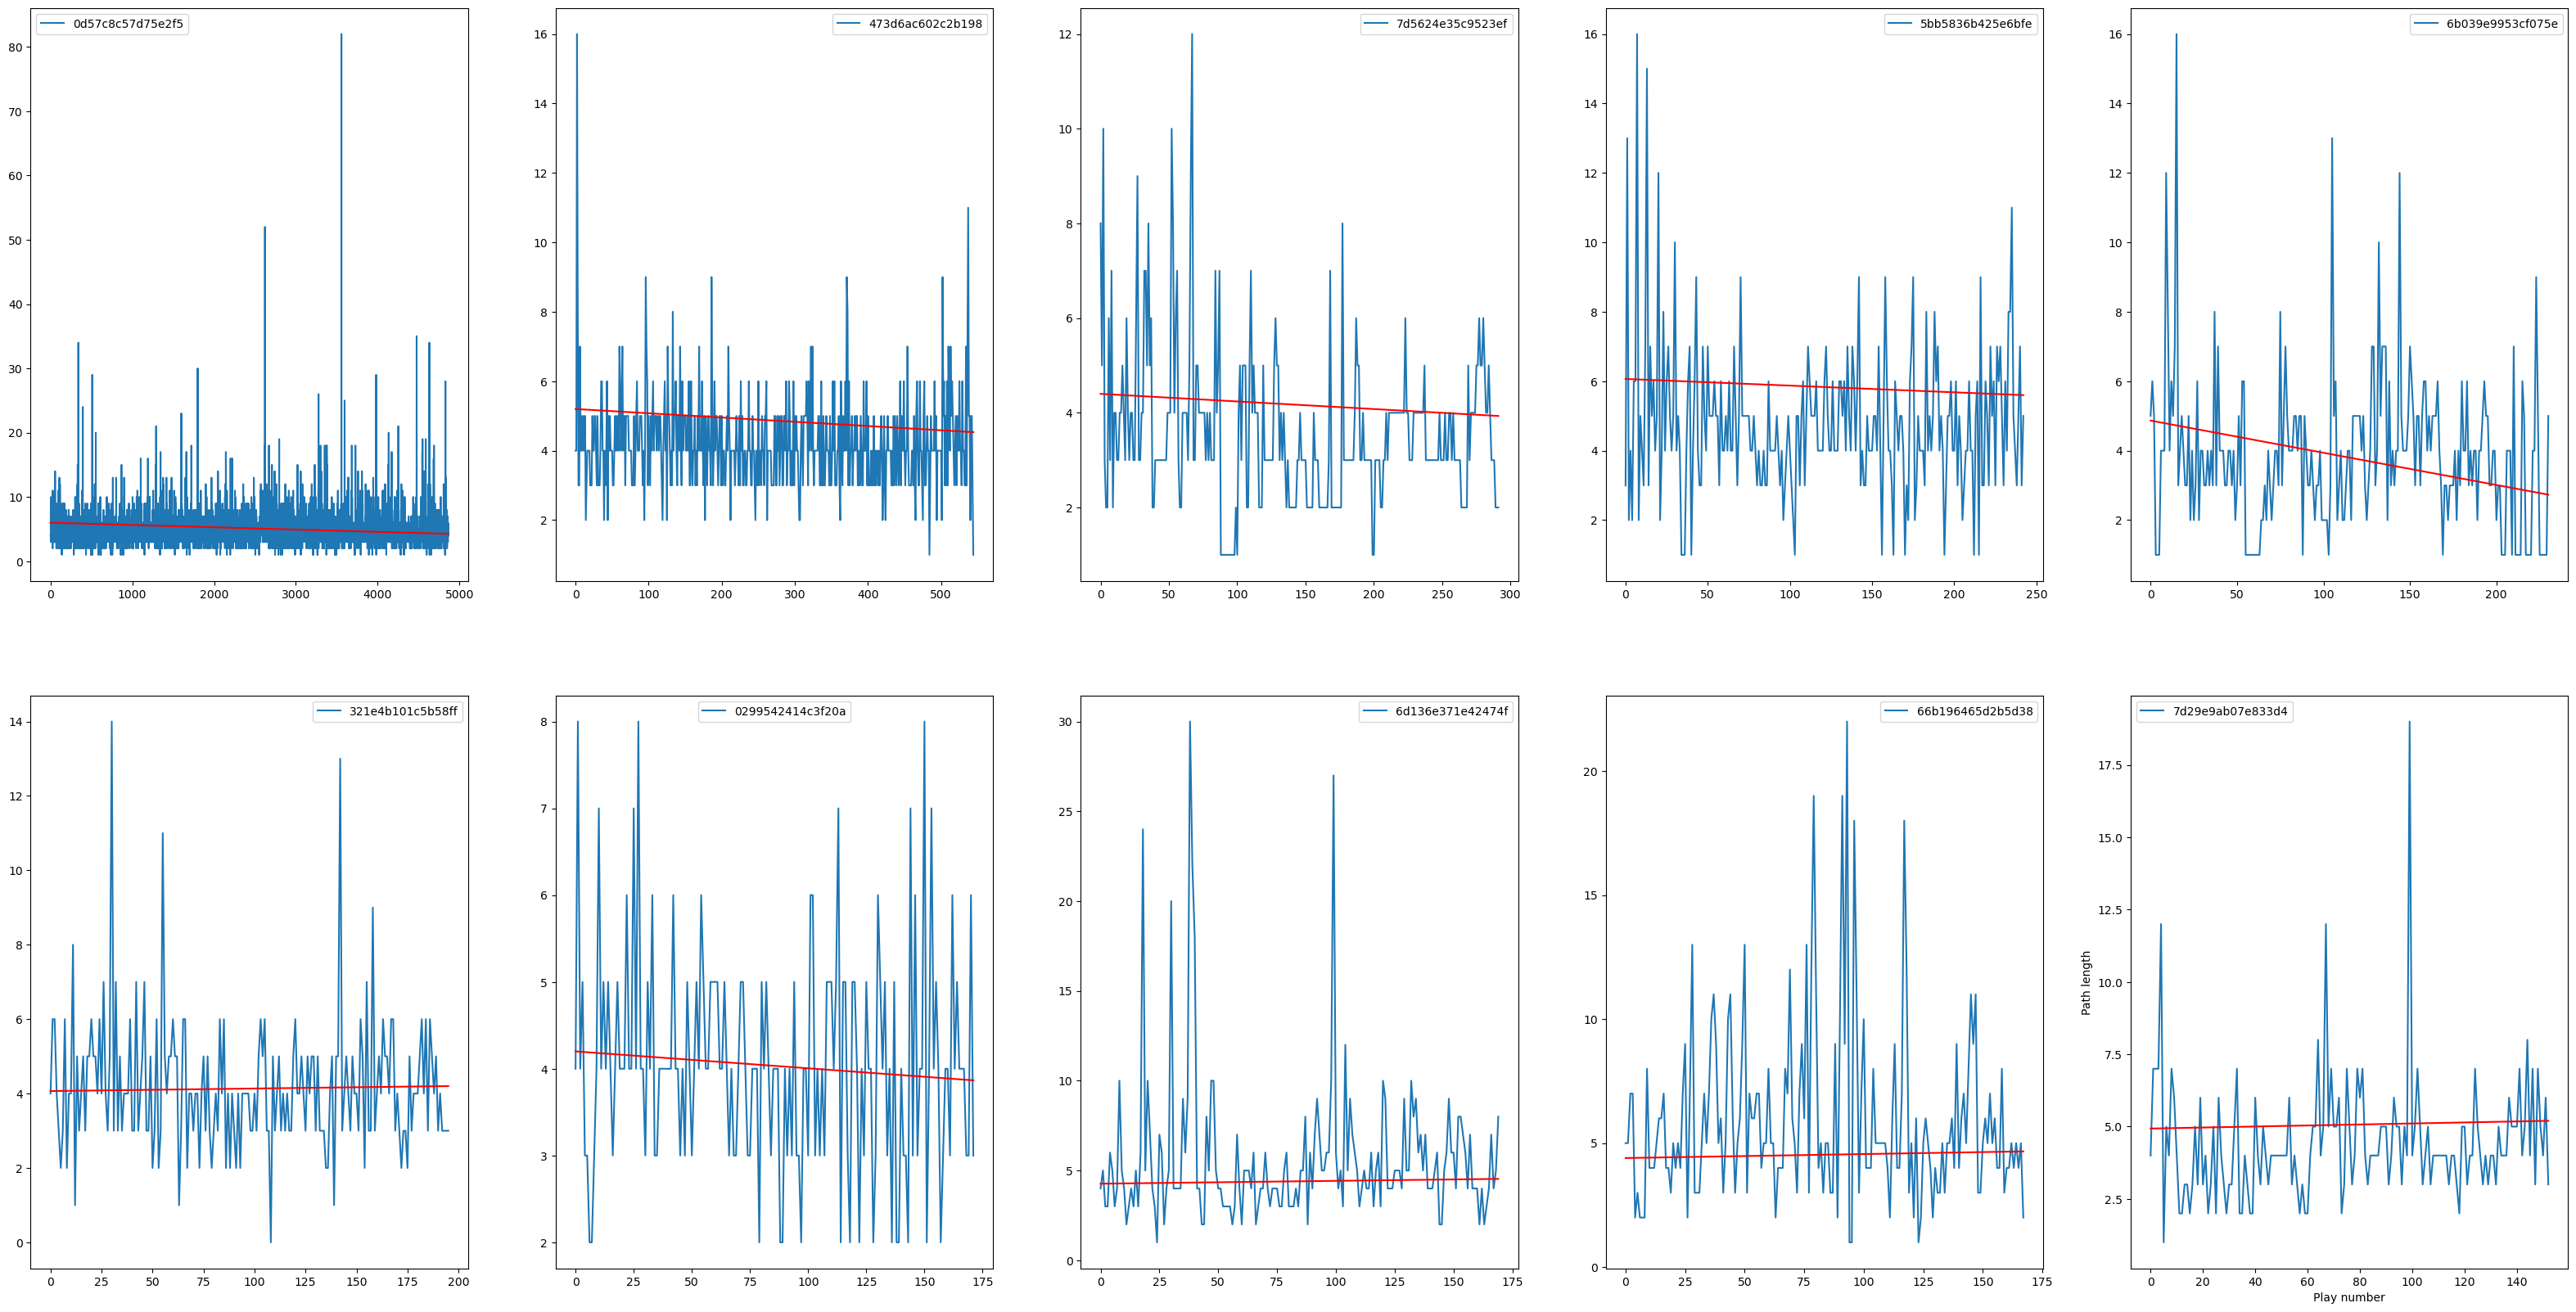

In [9]:
fig, axs = plt.subplots(2,5,figsize=(40, 20))
for i in range(10) :
    player = top10_players.index[i]
    player_paths = ordered_top10_paths.loc[player]
    path_lenghts = player_paths["path_length"]
    path_lenghts.index = range(len(path_lenghts))
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    path_lenghts.plot(ax=ax, label=player, legend=True)
    slope = [path_lenghts[0:15].mean(),path_lenghts[-15:].mean()]
    ax.plot([0,len(path_lenghts)-1],[slope[0],slope[1]], label="slope", color="red")


plt.xlabel("Play number")
plt.ylabel("Path length")

    


# IS GEOGRAPHY THE SOLUTION ?

To compare let's start by finding the most common pair of s-t 

In [29]:
#add start and end node of each path to the dataframe
finished_paths['(s,t)'] = finished_paths.apply(lambda x: (x['path'][0], x['path'][-1]), axis=1)
finished_paths['source' ] = finished_paths.apply(lambda x: x['(s,t)'][0], axis=1)
finished_paths['target'] = finished_paths.apply(lambda x: x['(s,t)'][1], axis=1)
finished_paths.head(2)

,hashedIpAddress,timestamp,durationInSec,path,rating,nb_clicks,nb_back_clicks,path_length,"(s,t)",source,target
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",-1,8,0,8,"(14th_century, African_slave_trade)",14th_century,African_slave_trade
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3,4,0,4,"(14th_century, African_slave_trade)",14th_century,African_slave_trade


In [11]:
#find the 10 most common combinations of start and end nodes
most_common_paths = finished_paths['(s,t)'].value_counts().head(10)
most_common_paths

(s,t)
(Asteroid, Viking)           1043
(Brain, Telephone)           1040
(Theatre, Zebra)              905
(Pyramid, Bean)               642
(Batman, Wood)                148
(Bird, Great_white_shark)     138
(Batman, The_Holocaust)       119
(Bird, Adolf_Hitler)          107
(Beer, Sun)                    99
(Batman, Banana)               69
Name: count, dtype: int64

To see if they pass by geography let's convert each node to its corresponding category

In [30]:
categories = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', comment='#')
categories.columns = ["article", "category"]
categories["category"] = categories["category"].apply(lambda x: x.split(".")[1:])
categories.head(2)

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]"
1,%C3%85land,[Countries]


In [19]:
filtered_paths = finished_paths[finished_paths['(s,t)' ].isin(most_common_paths.index.tolist())]

In [14]:
#testing function
print(get_category("Aristotle"))

['People', 'Philosophers']


In [22]:
filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article) for article in x])

C:\Users\matis\AppData\Local\Temp\ipykernel_18896\1903230909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article) for article in x])


In [23]:
filtered_paths['category_paths'].head(2)

1431    [[Everyday_life, Cartoons], [Geography, Geogra...
1432    [[Everyday_life, Cartoons], [Science, Chemistr...
Name: category_paths, dtype: object

In [25]:
#let's try our function with an imaginary category path
test = [['no', 'yes', 'no'], ['no', 'no', 'no'], ['Geography']]
print(contains_category(test, 'Geography')) #should return True
test = [['no', 'yes', 'no'], ['no', 'no', 'no'], ['History']]
print(contains_category(test, 'Geography')) #should return False
test = [['History', 'Geography']]
print(contains_category(test, 'Geography')) #should return True

['no', 'yes', 'no']
['no', 'no', 'no']
['Geography']
True
['no', 'yes', 'no']
['no', 'no', 'no']
['History']
False
['History', 'Geography']
True


In [ ]:
filtered_paths['Path_has_geography'] = filtered_paths['category_paths'].apply(lambda x: contains_category(x, 'Geography'))


In [32]:
plays_with_geo = filtered_paths[filtered_paths['Path_has_geography'] == True]
plays_without_geo = filtered_paths[filtered_paths['Path_has_geography'] == False]

In [33]:
plays_with_geo.groupby('(s,t)')['path_length'].mean()

(s,t)
(Asteroid, Viking)            6.064236
(Batman, Banana)              6.740741
(Batman, The_Holocaust)       4.271186
(Batman, Wood)                5.883929
(Beer, Sun)                   3.857143
(Bird, Adolf_Hitler)          4.500000
(Bird, Great_white_shark)    11.000000
(Brain, Telephone)            7.904110
(Pyramid, Bean)               7.582222
(Theatre, Zebra)              6.362590
Name: path_length, dtype: float64

In [35]:
plays_with_geo.shape

(1904, 13)

In [34]:
plays_without_geo.groupby('(s,t)')['path_length'].mean()

(s,t)
(Asteroid, Viking)           5.691649
(Batman, Banana)             5.190476
(Batman, The_Holocaust)      4.000000
(Batman, Wood)               4.833333
(Beer, Sun)                  4.227273
(Bird, Adolf_Hitler)         3.980392
(Bird, Great_white_shark)    4.283582
(Brain, Telephone)           5.248190
(Pyramid, Bean)              5.381295
(Theatre, Zebra)             4.919048
Name: path_length, dtype: float64

In [36]:
plays_without_geo.shape

(2406, 13)

# What are the most usefull domains, what is the best thing to learn ?

Putting stuff togethere to make it cleaner.

In [24]:
file_finished = "data/wikispeedia_paths-and-graph/paths_finished.tsv"
column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
finished_paths = pd.read_csv(file_finished, sep="\t", comment="#", names=column_names)

In [25]:
categories = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', comment='#')
categories.columns = ["article", "category"]
categories["category"] = categories["category"].apply(lambda x: x.split(".")[1:])
categories.head(2)

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]"
1,%C3%85land,[Countries]


In [16]:
all_categories = pd.DataFrame(categories['category'].explode().unique(), columns=['unique_categories'])
#remove None values
all_categories = all_categories[all_categories['unique_categories'].notna()]

In [ ]:
main_categories = categories['category'].apply(lambda x: x[0]).unique()
main_categories = pd.DataFrame(main_categories, columns=['main_categories'])
main_categories = main_categories[main_categories['main_categories'].notna()]

array(['People', 'Countries', 'Geography', 'History', 'Business_Studies',
       'Science', 'Everyday_life', 'Design_and_Technology', 'Music', 'IT',
       'Language_and_literature', 'Mathematics', 'Religion', 'Art',
       'Citizenship'], dtype=object)

In [26]:
# Split the path into a list
finished_paths["path"] = finished_paths["path"].apply(lambda x: x.split(";"))

# Count the number of clicks in each path (including back clicks)
finished_paths = finished_paths.assign(nb_clicks=finished_paths["path"].apply(lambda x: len(x)-1)) # -1 because we don't count the source article

# Count the number of back clicks in each path
finished_paths = finished_paths.assign(nb_back_clicks=finished_paths["path"].apply(lambda x: x.count("<")))

# Count the path length (excluding back clicks)
finished_paths = finished_paths.assign(path_length=finished_paths["nb_clicks"] - 2 * finished_paths["nb_back_clicks"])

# Convert the rating to int
finished_paths["rating"] = finished_paths["rating"].fillna(-1).astype(int) #0 means no rating

#add start and end node of each path to the dataframe
finished_paths['(s,t)'] = finished_paths.apply(lambda x: (x['path'][0], x['path'][-1]), axis=1)
finished_paths['source' ] = finished_paths.apply(lambda x: x['(s,t)'][0], axis=1)
finished_paths['target'] = finished_paths.apply(lambda x: x['(s,t)'][1], axis=1)
finished_paths.head(2)

,hashedIpAddress,timestamp,durationInSec,path,rating,nb_clicks,nb_back_clicks,path_length,"(s,t)",source,target
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",-1,8,0,8,"(14th_century, African_slave_trade)",14th_century,African_slave_trade
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3,4,0,4,"(14th_century, African_slave_trade)",14th_century,African_slave_trade


In [149]:
top_common = 10 #number of most common paths to consider

most_common_paths = finished_paths['(s,t)'].value_counts().head(top_common)
filtered_paths = finished_paths[finished_paths['(s,t)'].isin(most_common_paths.index.tolist())]
filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article, categories) for article in x])

C:\Users\matis\AppData\Local\Temp\ipykernel_27256\3245266276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article, categories) for article in x])


In [156]:
def categories_traversed(path, categories):
    path_flatten = [item for sublist in path for item in sublist]
    seen = list(set(path_flatten))
    categories_seen = [cat for cat in seen if cat in categories]
    numb_seen = len(categories_seen)
    return numb_seen


In [157]:
filtered_paths['numb_main_cat'] = filtered_paths['category_paths'].apply(lambda x: categories_traversed(x, main_categories['main_categories'].values))

C:\Users\matis\AppData\Local\Temp\ipykernel_27256\68585441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths['numb_main_cat'] = filtered_paths['category_paths'].apply(lambda x: categories_traversed(x, main_categories['main_categories'].values))


In [159]:
import numpy as np

def compare_lenghts_category(filtered_paths, category, top_common=10) :
    df = filtered_paths.copy()
    df['Path_has_category'] = df['category_paths'].apply(lambda x: contains_category(x, category))
    plays_with_category = df[df['Path_has_category'] == True]
    plays_without_category = df[df['Path_has_category'] == False]
    col_with_name = 'with_' + category
    col_without_name = 'without_' + category
    col_with_seen_cat = 'main_seen_when' + category
    col_without_seen_cat = 'main_seen_without' + category
    # comparison[col_with_name] += plays_with_category.groupby('(s,t)')['path_length'].mean()
    # comparison[col_without_name] += plays_without_category.groupby('(s,t)')['path_length'].mean()
    #comparison['avg_diff'] = comparison[col_with_name] - comparison[col_without_name]
    paths = most_common_paths.index.tolist()
    comparison = pd.DataFrame(index=paths, columns=[col_with_name, col_without_name, col_with_seen_cat, col_without_seen_cat])
    for idx, path in enumerate(paths) :
        with_cat = plays_with_category[plays_with_category['(s,t)'] == path]
        without_cat = plays_without_category[plays_without_category['(s,t)'] == path]
        with_cat_avg = with_cat['path_length'].mean() if with_cat.shape[0] > 0 else 0
        without_cat_avg = without_cat['path_length'].mean() if without_cat.shape[0] > 0 else 0
        with_cat_seen_cat = with_cat['numb_main_cat'].mean() if with_cat.shape[0] > 0 else 0
        without_cat_seen_cat = without_cat['numb_main_cat'].mean() if without_cat.shape[0] > 0 else 0
        comparison.iloc[idx] = [with_cat_avg, without_cat_avg, with_cat_seen_cat, without_cat_seen_cat]
    comparison['avg_lenght_diff'] = comparison[col_with_name] - comparison[col_without_name]
    comparison['avg_seen_diff'] = comparison[col_with_seen_cat] - comparison[col_without_seen_cat]
    return comparison
    

In [160]:
#test function with geo to see if it works correctly
compare_lenghts_category(filtered_paths, 'Geography')

,with_Geography,without_Geography,main_seen_whenGeography,main_seen_withoutGeography,avg_lenght_diff,avg_seen_diff
"(Asteroid, Viking)",6.064236,5.691649,4.317708,4.012848,0.372587,0.30486
"(Brain, Telephone)",7.90411,5.24819,6.0,4.383661,2.655919,1.616339
"(Theatre, Zebra)",6.36259,4.919048,3.94964,3.2,1.443542,0.74964
"(Pyramid, Bean)",7.582222,5.381295,5.0,3.53717,2.200927,1.46283
"(Batman, Wood)",5.883929,4.833333,4.419643,3.416667,1.050595,1.002976
"(Bird, Great_white_shark)",11.0,4.283582,2.75,1.022388,6.716418,1.727612
"(Batman, The_Holocaust)",4.271186,4.0,3.847458,3.05,0.271186,0.797458
"(Bird, Adolf_Hitler)",4.5,3.980392,4.660714,3.647059,0.519608,1.013655
"(Beer, Sun)",3.857143,4.227273,3.220779,2.681818,-0.37013,0.538961
"(Batman, Banana)",6.740741,5.190476,2.888889,2.119048,1.550265,0.769841


In [161]:
for cat in main_categories['main_categories'] :
    print(cat)
    print(compare_lenghts_category(filtered_paths, cat))

People
                          with_People without_People main_seen_whenPeople  \
(Asteroid, Viking)           5.972414       5.885301             4.737931   
(Brain, Telephone)             7.1875       5.152902             5.243056   
(Theatre, Zebra)             7.410959        5.90625              4.30137   
(Pyramid, Bean)             11.944444       5.985577             6.777778   
(Batman, Wood)                   13.0       5.527397                  7.0   
(Bird, Great_white_shark)           0       4.478261                    0   
(Batman, The_Holocaust)           5.1       4.045872                  4.6   
(Bird, Adolf_Hitler)         4.252336              0              4.17757   
(Beer, Sun)                         0       3.939394                    0   
(Batman, Banana)                    0       5.797101                    0   

                          main_seen_withoutPeople avg_lenght_diff  \
(Asteroid, Viking)                       4.091314        0.087113   
(Brain,